This is thhe code which separates the particles from the background. 

In [1]:
import numpy as np
import skimage
import skvideo.io
from operator import attrgetter
import seaborn as sns
from itertools import chain
from skimage import measure,morphology
from skimage.morphology import diameter_closing
from skimage.filters import *
from glob import glob


'Currently works on a single frame. Later, will add a loop that can work on all frames.'

In [2]:
filename = glob("./tchakamau/De*styrene/*7.avi")[0]
print(filename)

./tchakamau\Density_matchedstyrene\45696_15Vpp_7.avi


Load the video and make sure it loaded correctly. 

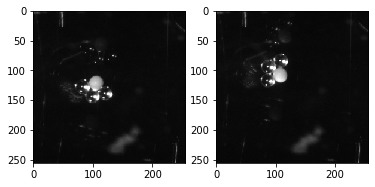

In [3]:
Vid = skvideo.io.vread(filename)

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(Vid[0]) # first fame of video
ax[1].imshow(Vid[-1]) #last frame of video
green = Vid[:, :, :, 2] # we filmed in black and white, ergo, the green channel only will suffice
print(green.shape, len(Vid))


(30491, 256, 256)


Text(0.5, 1.0, 'Truncated histogram')

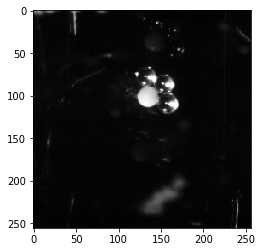

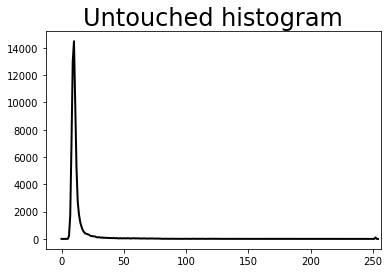

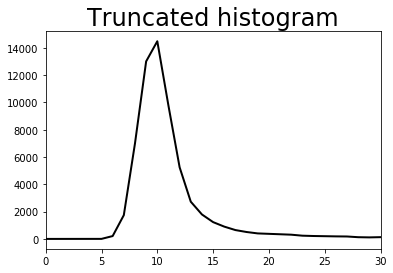

In [4]:

# Histogram
fig, ax1 = plt.subplots()
values, bins = np.histogram(green[500],
                            bins=np.arange(256))

ax1.plot(bins[:-1], values, lw=2, c='k')
ax1.set_xlim(xmax=256)
ax1.set_title('Untouched histogram', fontsize=24)


fig, ax1 = plt.subplots()
values, bins = np.histogram(green[500],
                            bins=np.arange(256))

ax1.plot(bins[:-1], values, lw=2, c='k')
ax1.set_xlim(xmax=30, xmin = 0)
ax1.set_title('Truncated histogram', fontsize=24)

This runs through some example thresholding functions. Each of the functions from the graph image is available from scikit-image  under filters.

I like these functions because they use an algorithm to threshold and so they should adapt to differing brighntesses from image to image, but you could always used a fixed value as your threshold. Whatever the thrreeshold value, pixels with brightnesss above this are white and the rest are black in the thresholded image. 
The exaqmpels show what kind of contrast ou have in the image between foreground and background. You can see which functions separate the glass dots from each other and which do not. Some leave out the glass dots entirely or reduce them to mere specks which we can erase later, which is helpful. 

Here I try on three frames througout the video.

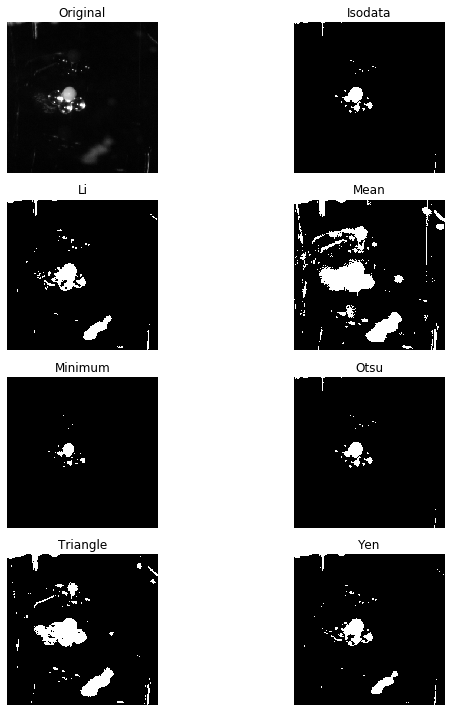

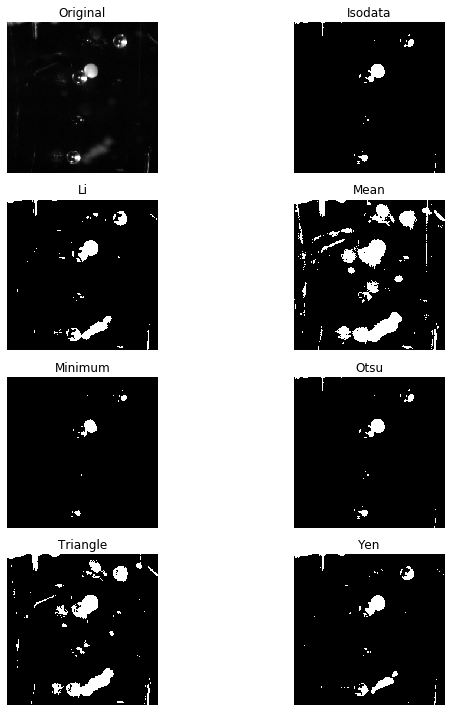

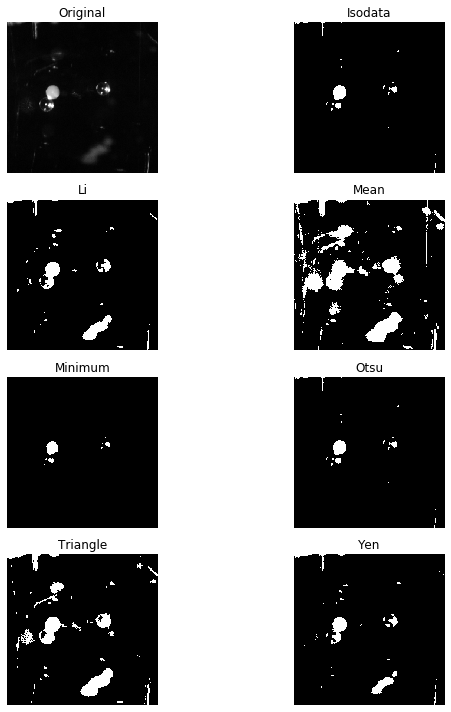

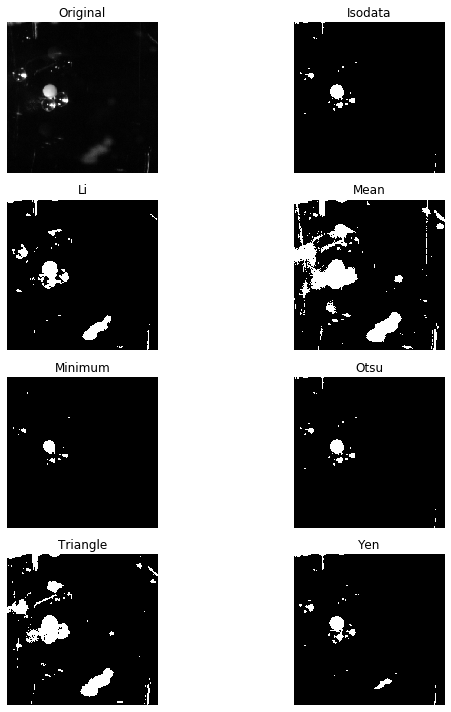

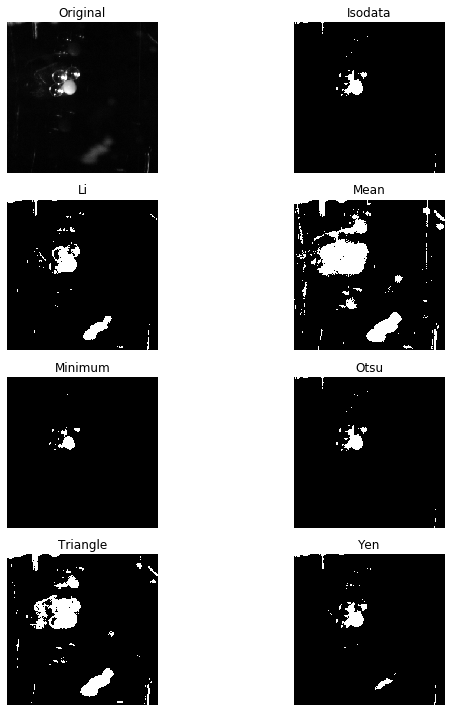

In [8]:
"Tryign built-in thresholds for separating image and background"
from skimage.filters import try_all_threshold
n = 3 # number of frames to try
for i in range(0, len(green), int(len(green)/n)):
    img = green[i]

    fig, ax = try_all_threshold(img, figsize=(10, 10), verbose=False)


I deal with the opaque and transparent particles separately, so I can look at connections within each group as well as across groups. This is an example of how you can isolate the opaque particles. 

I create a copy of the frame as the template. Then, I make another array called "highlight", which contains only the pixels brighter than the threshold, i.e. the opaque particle in its entirety and the bright reflections in the transparent particles.

Then I remove from the image 'template' any pizels which are too dark, i.e. those that are set to  zero when thresholding. I don't just use the thresholded image to work form here because some of the functions I use don't work on binary images, so I need to maintain the smooth gradient in intensities at the edges of the particles. Now I use 'blobs' to find the dots. This isn't the  result yet, but I want to print a preliminary step (the middle image) and see how many of the particles are recognizable. 

Next, I use a 'morphological opening' on the highlight, to remove any particles smaller than 14*14 pixels. This gets rid of the reflections, i.e. the transparent particles. I make another  template off the original image and subtract our anything that is not in the 'opened' highlight, leaving only the pixels of the original image that are of the opaque particle. 

Now I run blobs on this for real version of the image to get my particle. Seeing that this works, I'm good. 

The intermediate image, which is not part of the result, can be used for trying out stuff.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


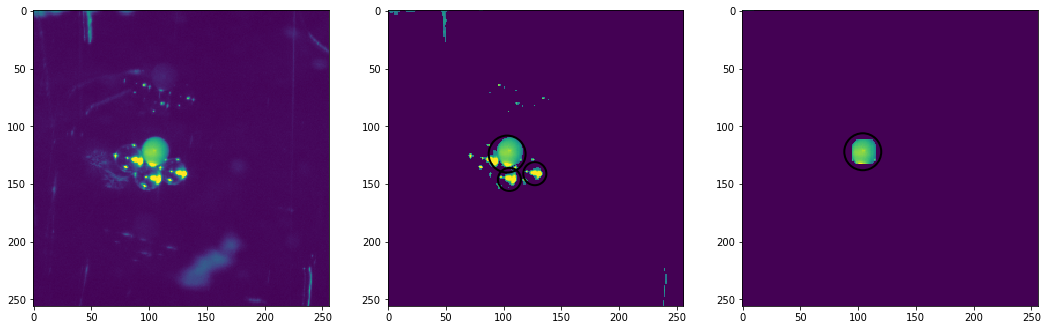

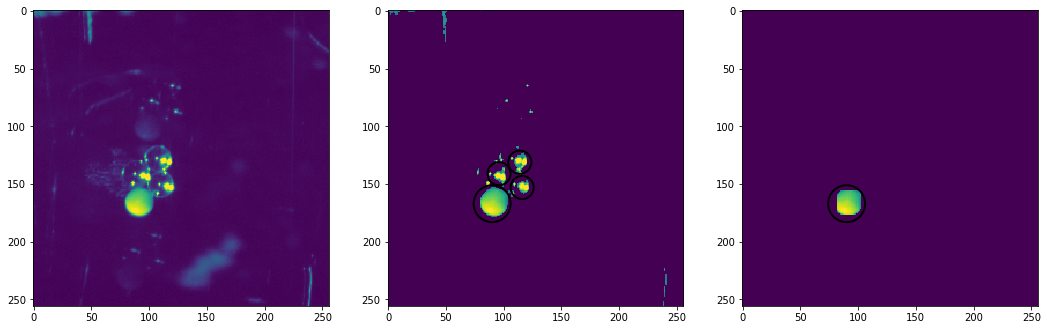

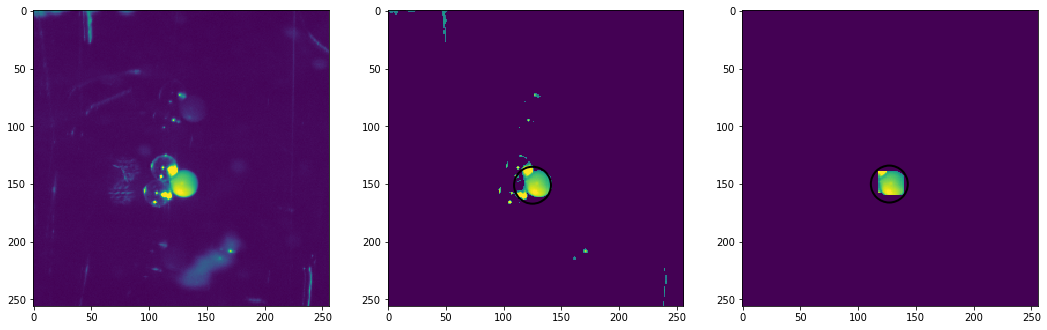

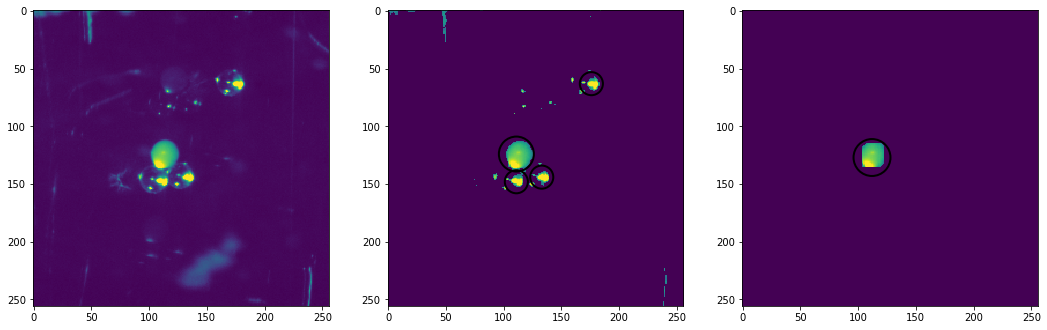

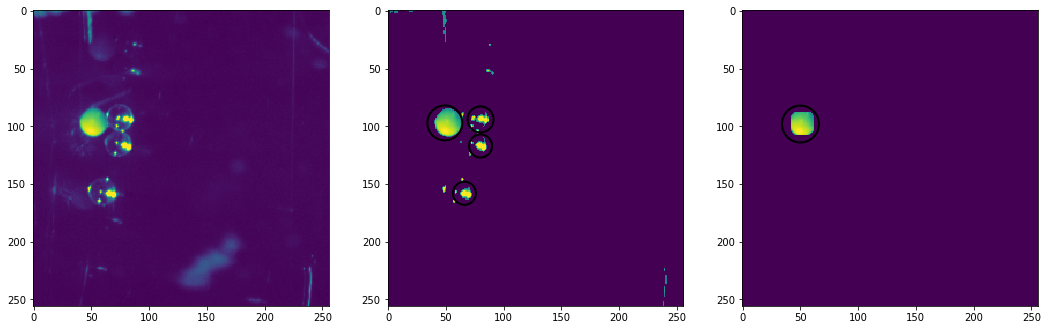

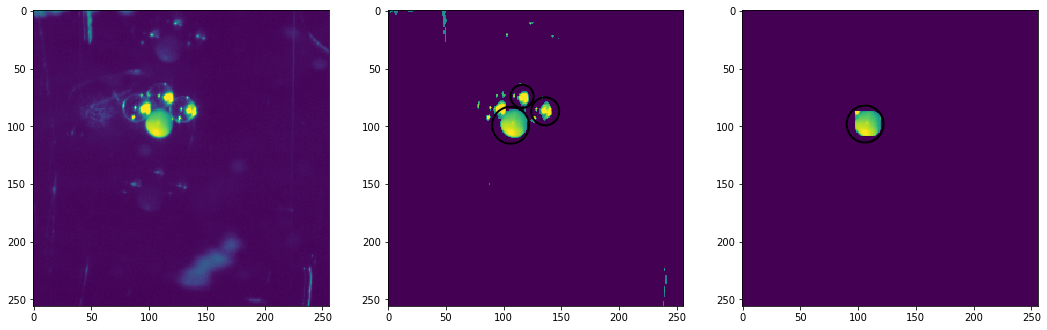

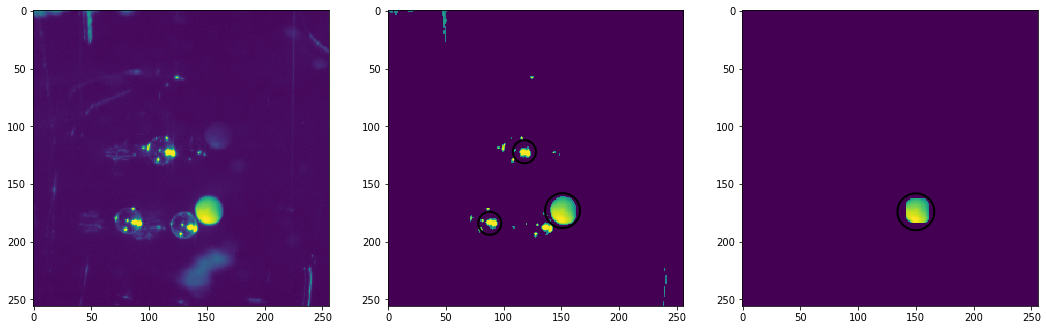

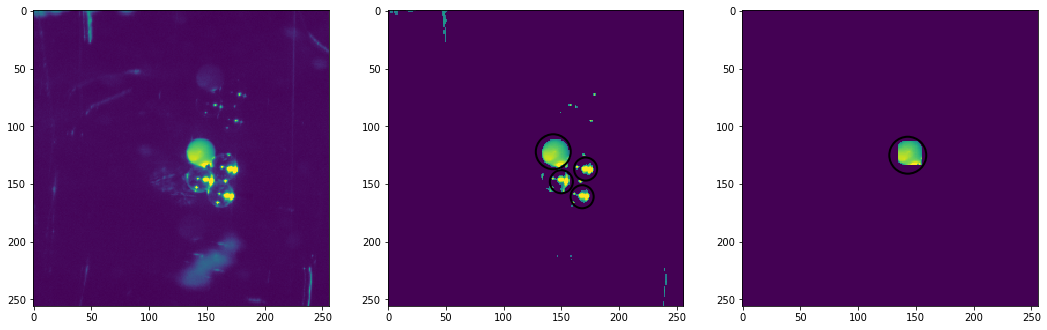

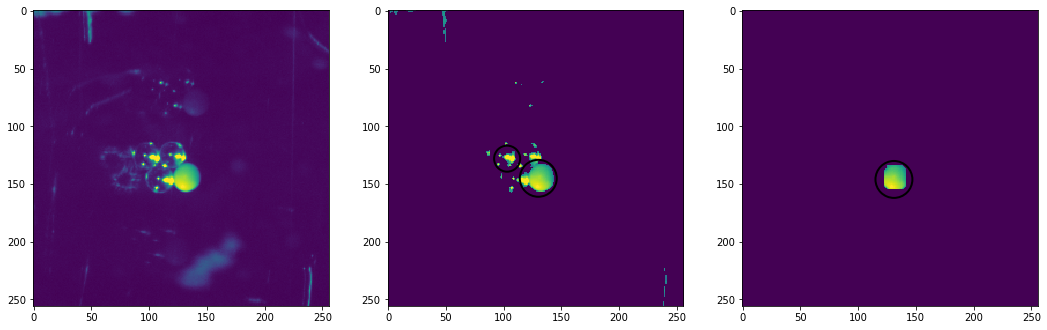

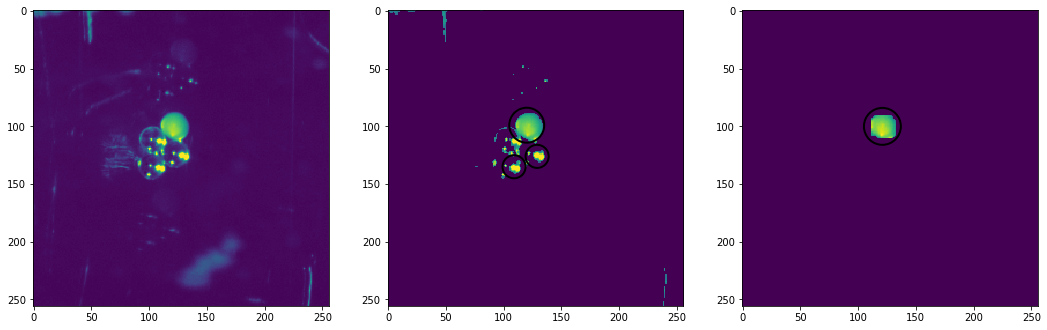

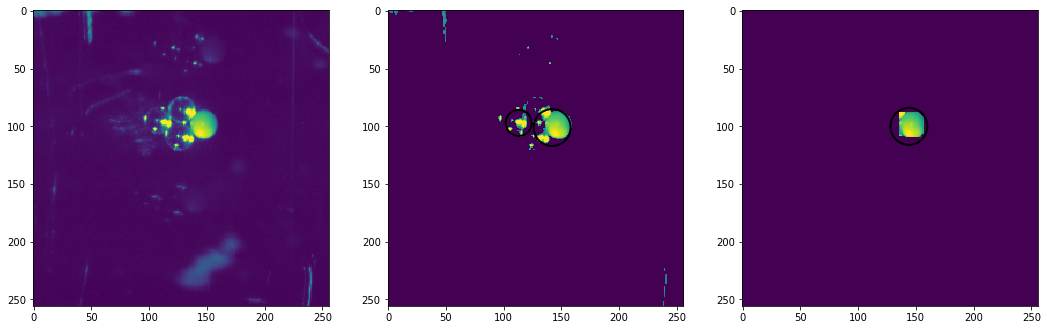

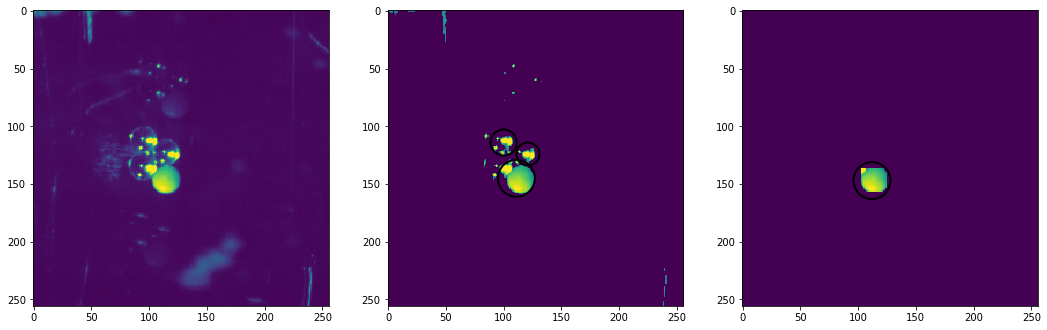

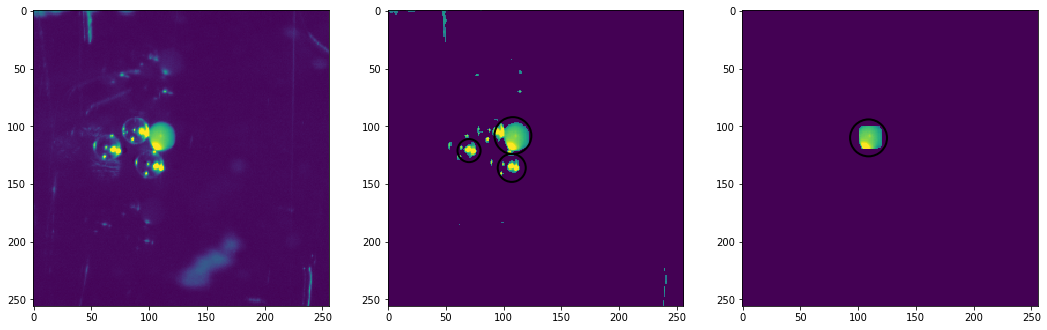

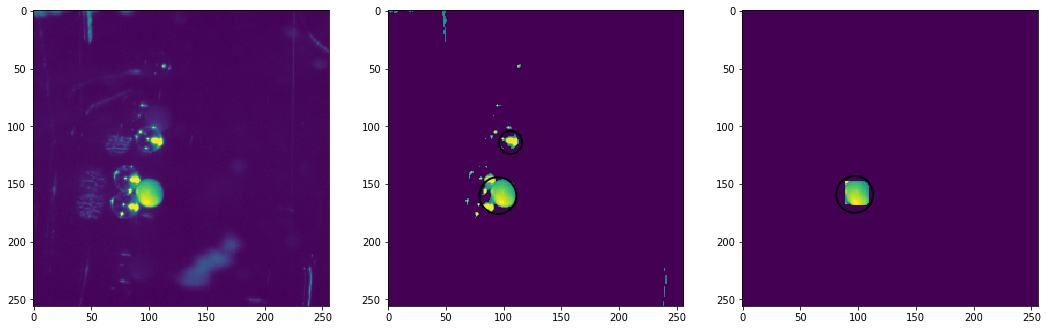

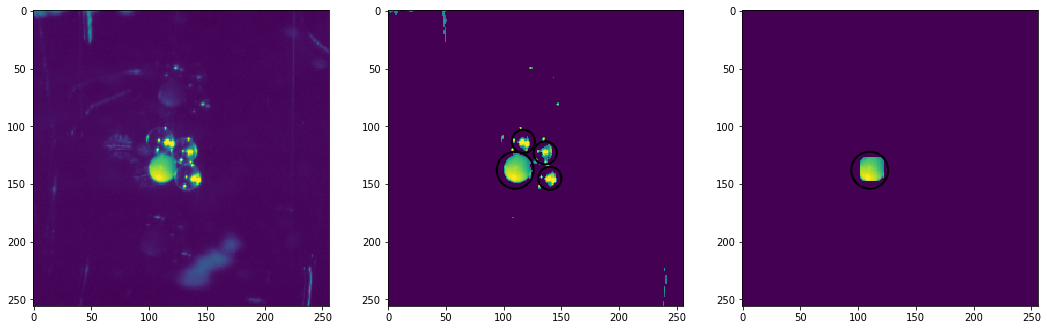

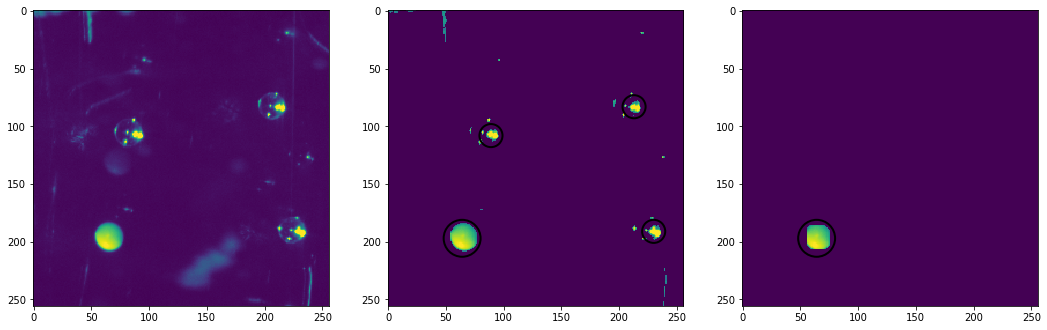

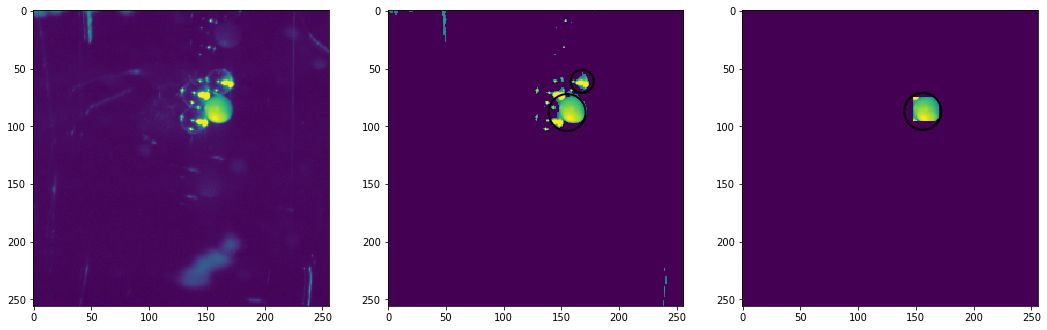

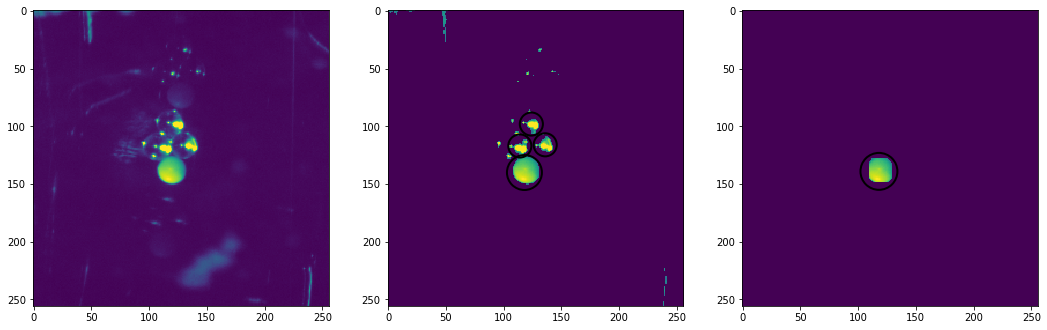

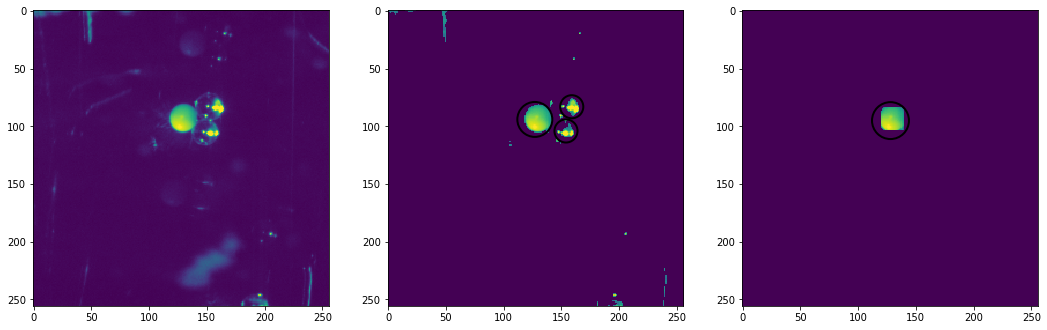

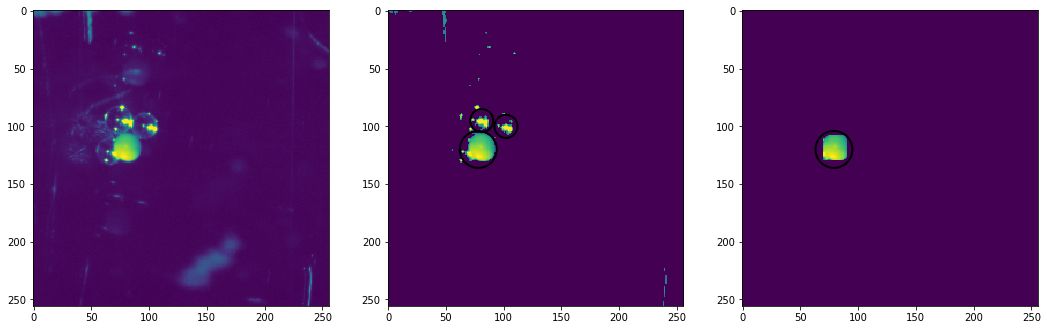

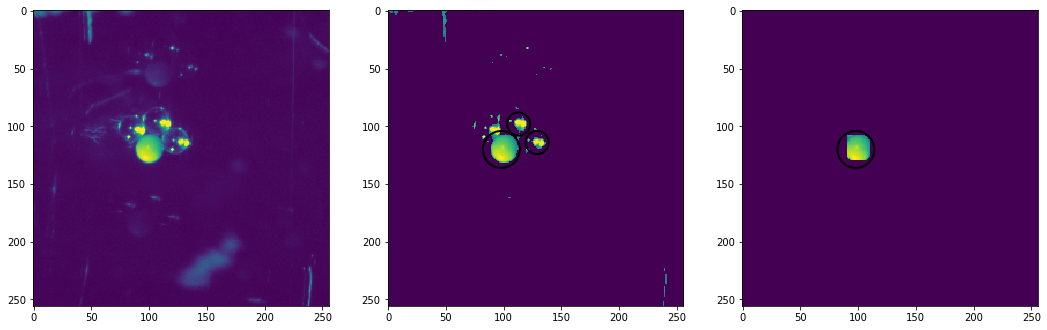

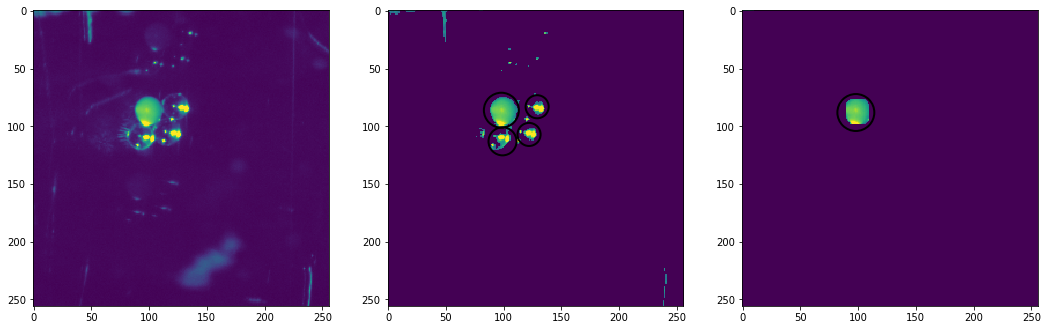

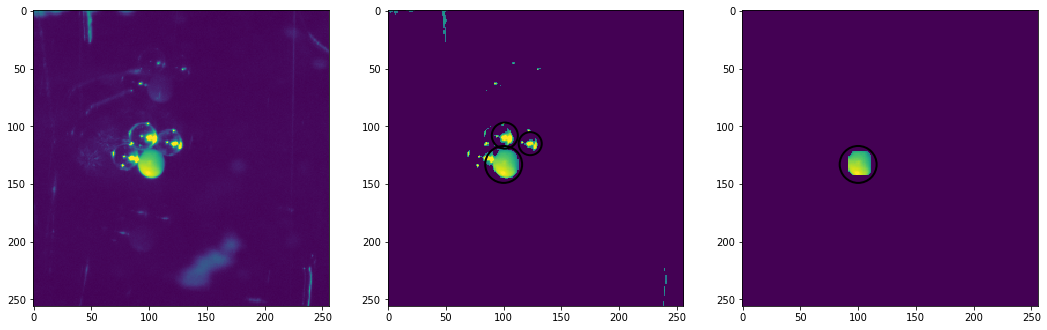

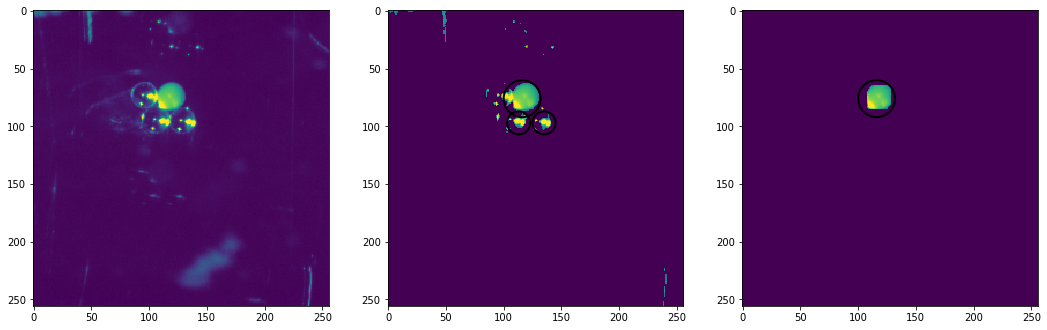

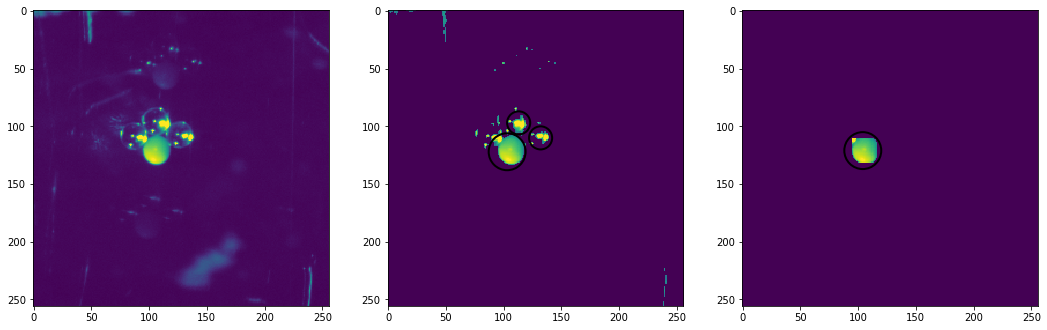

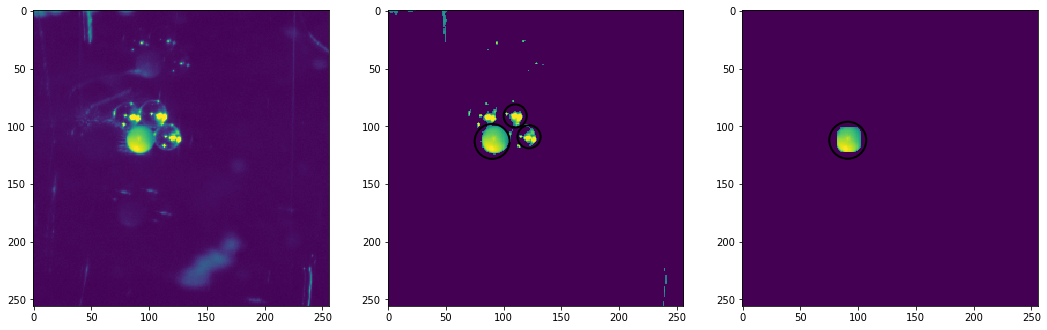

In [13]:
"""comparing filters"""
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import feature
from skimage.morphology import square


for i in range(0, len(green), int(len(green)/25)):
    highlight = green[i][0] > threshold_isodata(green[i][0]) # separate pixels  above vs below the threshold
    #                                       # threshold_isodata() provides the actual number representing the brightness
    img = np.copy(green[i][0])
    img[highlight==0] = 0
    blobs = skimage.feature.blob_doh(img, min_sigma = 10, max_sigma = 16, threshold = 0.009, num_sigma=15 )
    
    highlight2 =morphology.opening(green[i][0] > threshold_isodata(green[i][0]), square(14))
    img2 = np.copy(green[i][0])
    img2[highlight2==0] = 0
    blobs2 =skimage.feature.blob_doh(img2, min_sigma = 10, max_sigma = 16, threshold = 0.007, num_sigma= 15, overlap=0.6)
    
    fig, ax = plt.subplots(ncols = 3, figsize=(18, 8))
    ax[0].imshow(green[i][0])
    ax[1].imshow(img)
    for b in blobs:
        c = plt.Circle((b[1],b[0]), b[2], linewidth=2, fill=False)
        
        ax[1].add_patch(c)
    
    ax[2].imshow(img2)
    for b in blobs2:
        c = plt.Circle((b[1],b[0]), b[2], linewidth=2, fill=False)
        ax[2].add_patch(c)

This is like before except that white tophat removes everything above 14*14 pixels, while the opening removes everything below 4 pixels wide, so that only the reflections in the transparent particles are preserved. 

Since this relies on the off-center reflections, the detected blobs are shifted left/right copared to where they really are. This means you have to pretend the radius of a particle is slightly wider than it is later on to get the connections between every transparent particle annd the opaque ones.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


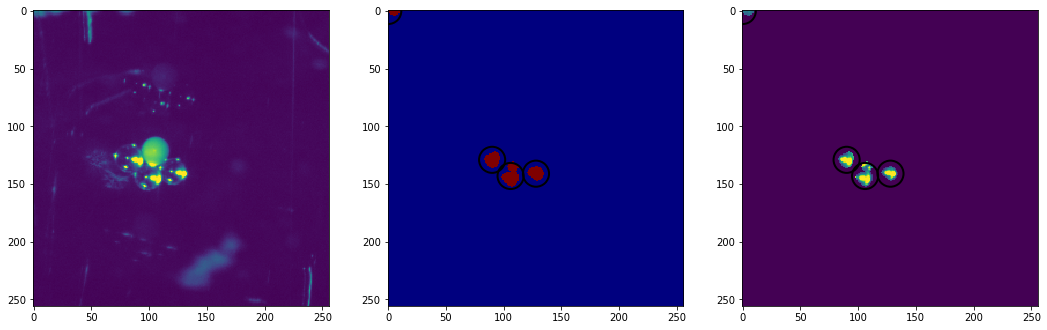

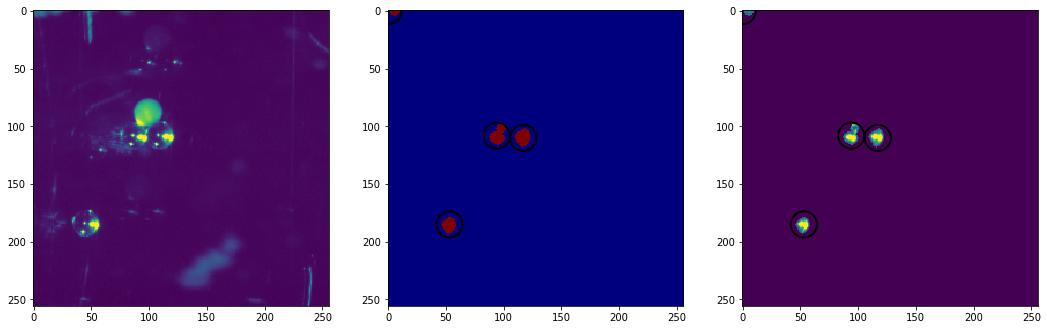

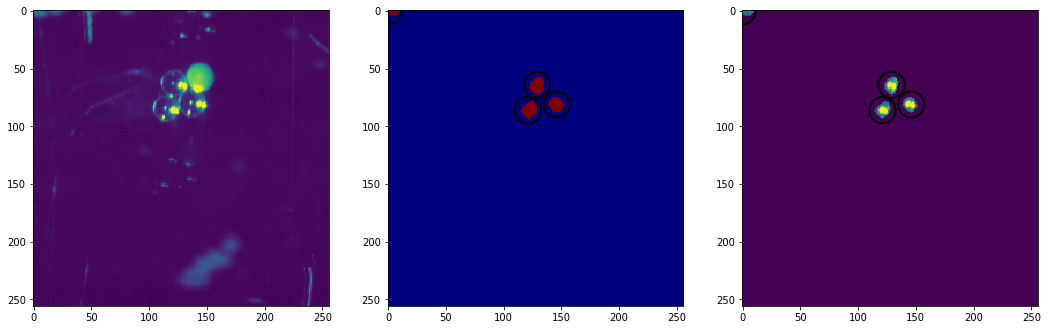

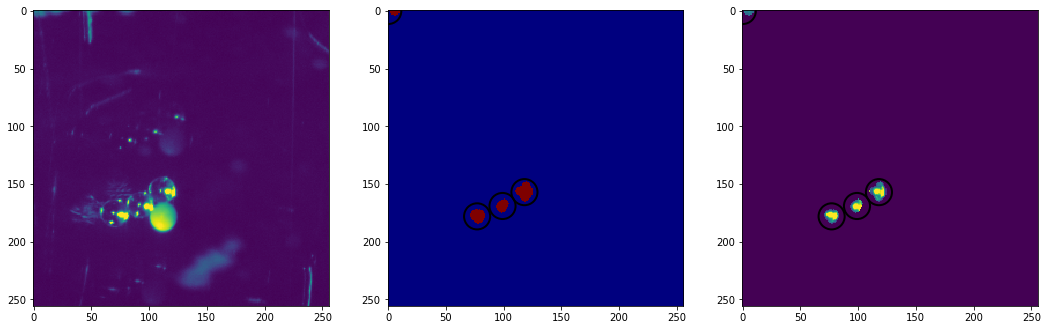

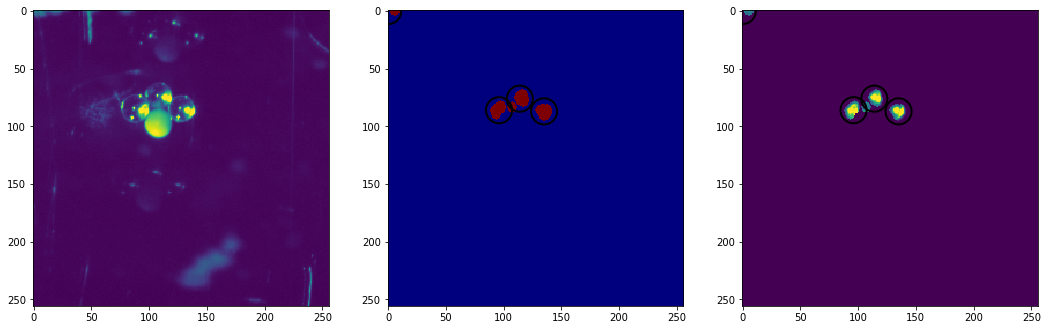

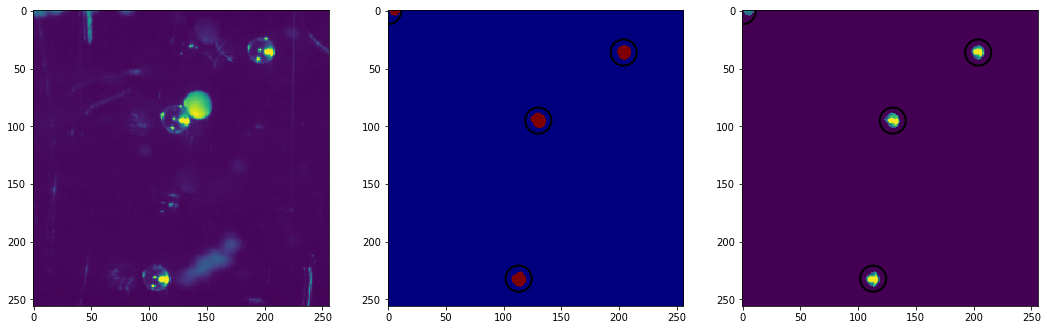

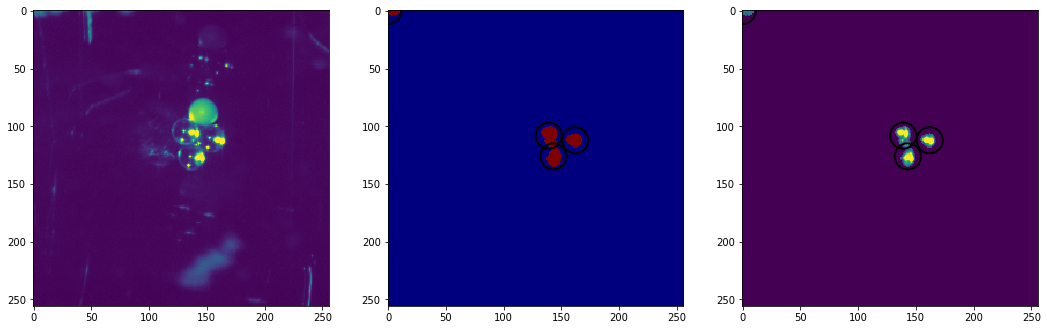

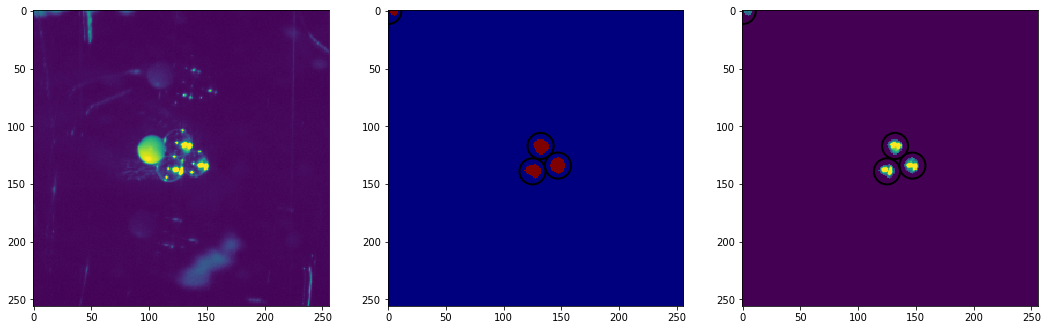

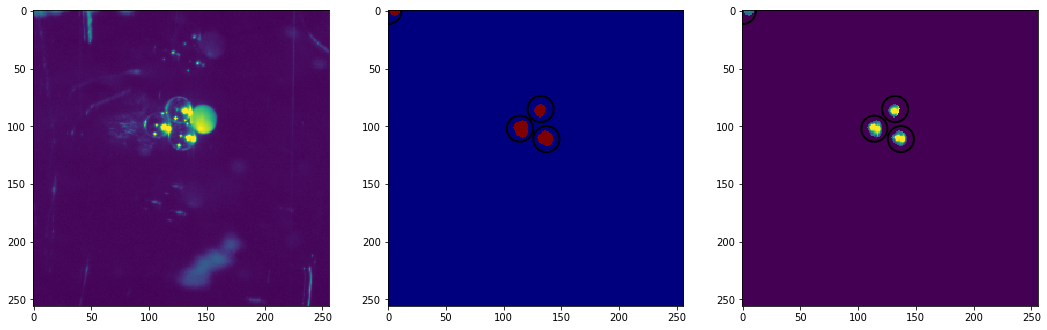

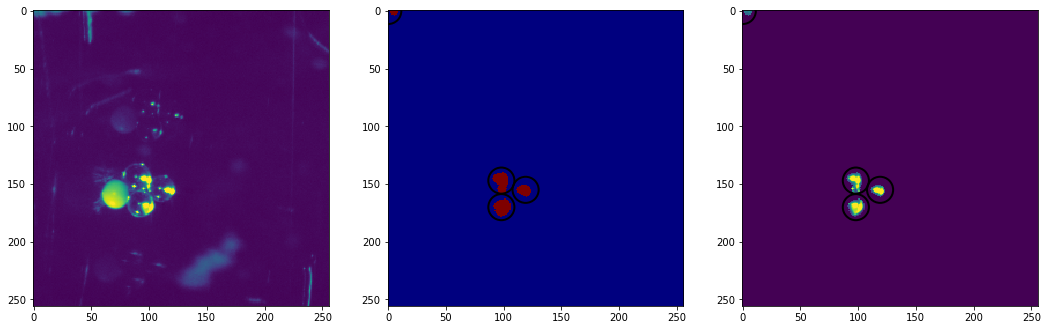

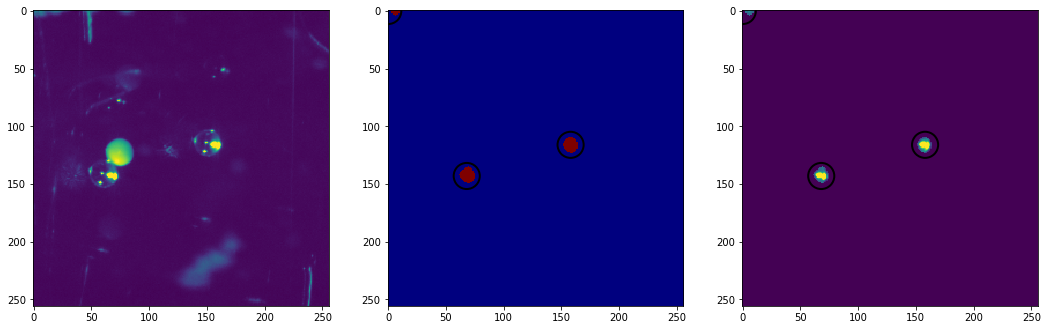

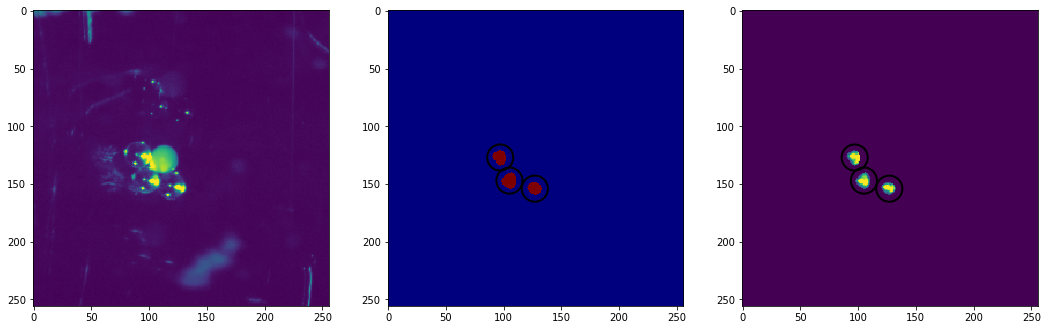

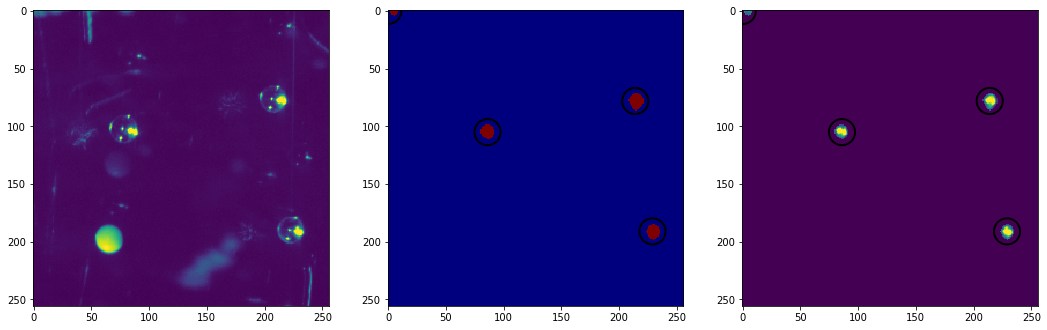

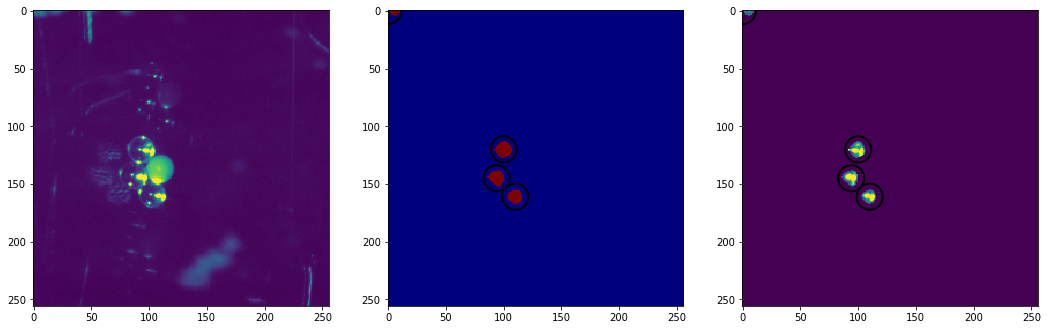

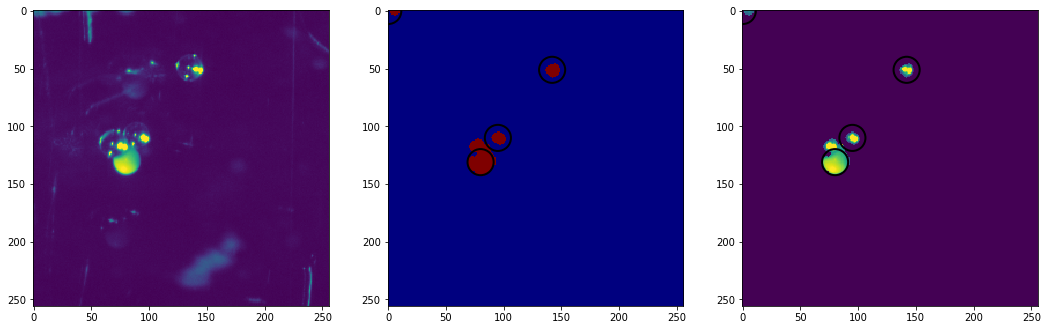

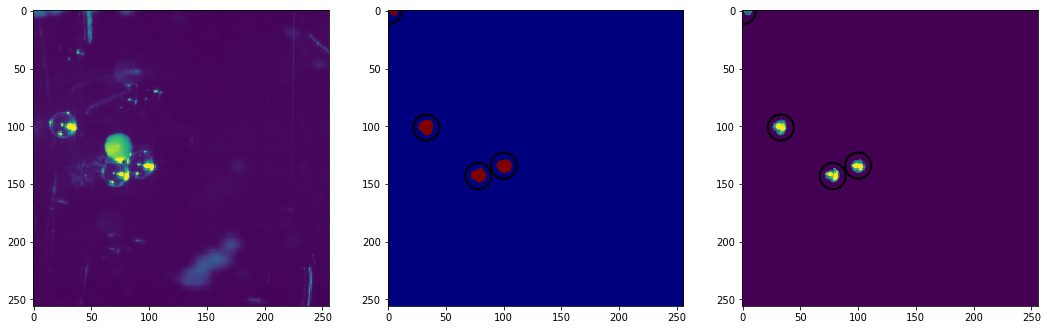

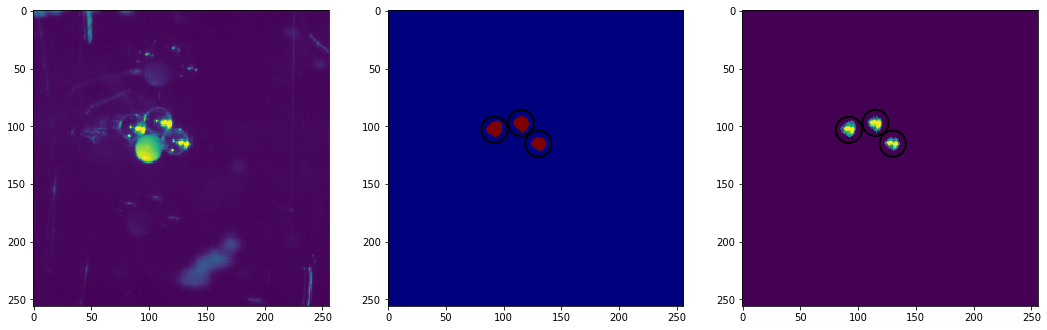

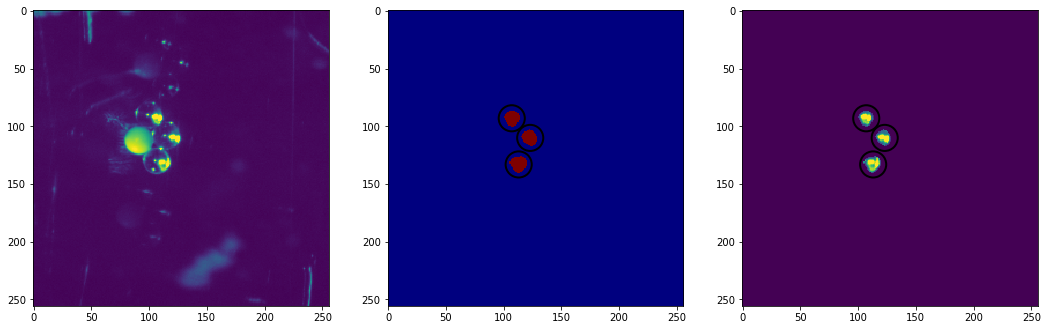

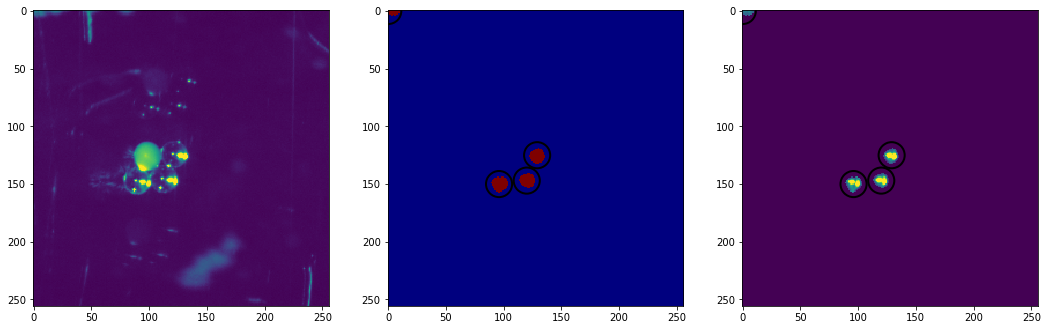

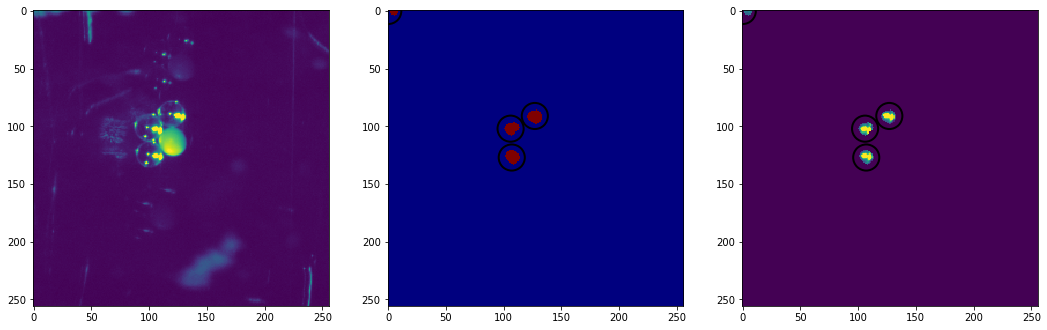

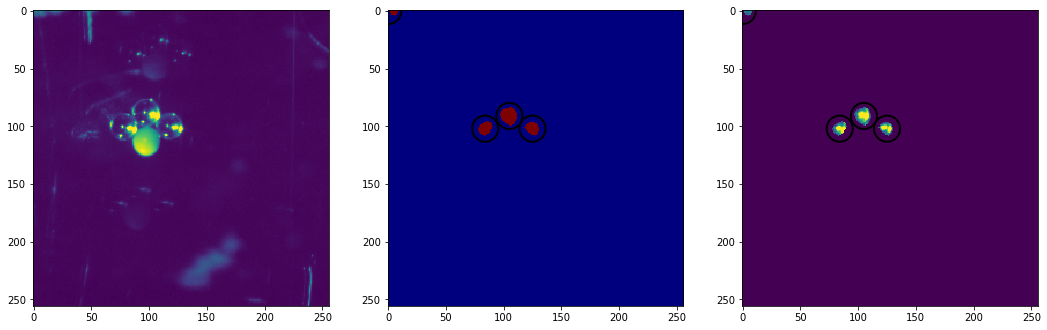

In [28]:
"""comparing filters"""
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import feature
from skimage.morphology import square, disk

for i in range(0, len(green), int(len(green)/20)):
    
    highlight2 =morphology.opening(
        morphology.white_tophat(gaussian(green[i][0] > threshold_isodata(green[i][0]), sigma=0.2), square(14)),
                                   disk(4))
    img2 = np.copy(green[i][0])
    img2[highlight2==0] = 0
    blobs2 =skimage.feature.blob_dog(img2, min_sigma = 8, max_sigma = 12, threshold = 0.2, overlap=0.5)
    blobs2[:, 2] = blobs2[:, 2] * np.sqrt(2)
    
    fig, ax = plt.subplots(ncols = 3, figsize=(18, 8))
    ax[0].imshow(green[i][0])
    highlight2[highlight2 != 0]=1
    ax[1].imshow(highlight2, cmap='jet')
    for b in blobs2:
        c = plt.Circle((b[1],b[0]), b[2], linewidth=2, fill=False)
        
        ax[1].add_patch(c)
    
    """ax[2].imshow(img2)
    for b in blobs2:
        c = plt.Circle((b[1],b[0]), b[2], linewidth=2, fill=False)
        ax[2].add_patch(c)"""
    ax[2].imshow(img2)
    for b in blobs2:
        c = plt.Circle((b[1],b[0]), b[2], linewidth=2, fill=False)
        ax[2].add_patch(c)